In [3]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

We simulate embedding an entity to the answer space directly. So the query is dependent on only one entity! Normal vectors are generated by a simple MLP model (one per band).

In [4]:

def plot_embeddings(embs):
    embs_temp = embs.clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.view_init(25, 10)

    # plot embeddings
    for emb in embs_temp:
        ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='blue')

In [5]:
"""Simple MLP model with 1 layer, simulating GCN model"""
class MLP(nn.Module):
    def __init__(self, batch_size, band_size):
        super().__init__()
        self.band_size = band_size
        self.embs = torch.nn.parameter.Parameter(data=torch.randn((batch_size, 3)))
        out_layer = 3 * band_size
        self.layers = nn.Sequential(nn.Linear(3, out_layer))
        
    def forward(self, input):
        # in: (batch_size, embed_dim)
        # out: (batch_size, band_size, embed_dim)
        x = self.layers(input)
        return x.reshape(input.size(0), self.band_size, input.size(1))

In [6]:
"""
Function that shuffles indexes (duplicates allowed) where at least we know
the new index is NOT the original index!
"""
def shuffled_indices(max_index):
    out = []
    for idx in range(max_index):
        out.append(random.choice([x for x in range(max_index) if not x == idx]))
    return out

shuffled_indices(20)


[2, 13, 11, 7, 2, 12, 9, 0, 5, 15, 5, 13, 10, 9, 8, 13, 7, 8, 12, 14]

In [31]:
def plot_answerspace(embs, space, batch_id=0):

    emb = embs[batch_id]    # (embed_dim)
    hyps = space[batch_id]  # (num_hyps, embed_dim)

    present = False
    also_present = []
    if torch.all(torch.sum(emb.reshape(1, -1) * hyps, dim=-1) > 0):
        present = True

        # see which embeddings are also present
        also_present = []
        # embs:     (num_ents, embed_dim)
        # space:    (batch, band_size, embed_dim)
        embs_1 = embs.reshape(embs.size(0), 1, embs.size(1))                # (num_ents, 1, embed_dim)
        space_1 = hyps.reshape(1, hyps.size(0), hyps.size(1))             # (1, num_hyps, embed_dim)
        dot_inds = (torch.sum(embs_1 * space_1, dim=-1) > 0)
        ent_inds = torch.all(dot_inds, dim=-1)
        for ent_id, ent_ind in enumerate(ent_inds):
            if ent_ind and (ent_id != batch_id):
                also_present.append(embs[ent_id].clone().detach().tolist())

    print(f"In band: {present}, visualized:")

    emb = emb.clone().detach().tolist()
    hyps = hyps.clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.view_init(25, 10)

    # plot target embedding
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='green')

    # plot normal vectors
    for hyp in hyps:
        ax.quiver(0, 0, 0, hyp[0], hyp[1], hyp[2], color='blue')

    if also_present:
        for vec in also_present:
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='red')

In [8]:
def predict(embs, space):
    answers = [[] for _ in range(embs.size(0))]

    space_1 = space.reshape(space.size(0), 1, space.size(1), space.size(2))          
    
    # add extra dimension for broadcasting:  
    # from  (num_ents_mode, embed_dim)
    # to    (1, num_ents_mode, 1, 1, embed_dim)
    embs_1 = embs.reshape(1, embs.size(0), 1, embs.size(1))

    # calculate dot products of hyperplanes-embeddings
    # and convert positive/negative dot products to binary values
    # shape: (batch_size_mode, num_ents_mode, num_bands, band_size)
    dot_inds = (torch.sum(space_1 * embs_1, dim=-1) > 0)

    # only if all hyperplanes in a band are positive and the band contains the answer
    # shape: (batch_size_mode, num_ents_mode, num_bands)
    band_inds = torch.all(dot_inds, dim=-1)
    
    # iterate through all batches
    for batch_idx, batch in enumerate(band_inds):
        # for all entities for that batch
        for ent_idx, ent_ind in enumerate(batch):
            # if the entity indicator is True (is in any band's answer space)
            if ent_ind:
                # we add the global entity index (=ID) to the answer list for that batch
                answers[batch_idx].append(ent_idx)
    return answers


In [9]:
cos = torch.nn.CosineSimilarity(dim=-1)

In [87]:
def loss_function(hyp, pos, negs):
    # hyp shape:    (batch, band_size, embed_dim)
    # embs shape:   (batch, embed_dim)
    # negs shape:   (batch, embed_dim)

    pos_ = pos.reshape(pos.size(0), 1, pos.size(1))     # shape: (batch, 1, embed_dim)
    pos_dot_norm = cos(pos_, hyp)                       # shape: (batch, band_size)

    neg_ = negs.reshape(negs.size(0), 1, negs.size(1))  # shape: (batch, 1, embed_dim)
    neg_dot_norm = cos(neg_, hyp)                       # shape: (batch, band_size)

    # calculate band distance:
    # cosine distance is in range[-1, 1] (where 1 is CLOSE)
    # we want to maximize closeness for positive samples, so we minimize -distance
    pos_distance = -torch.mean(pos_dot_norm, dim=-1)
    neg_distance = -torch.mean(neg_dot_norm, dim=-1)

    # calculate margin loss
    loss = pos_distance - neg_distance
    return torch.mean(loss), torch.mean(pos_distance).detach().item(), torch.mean(neg_distance).detach().item()

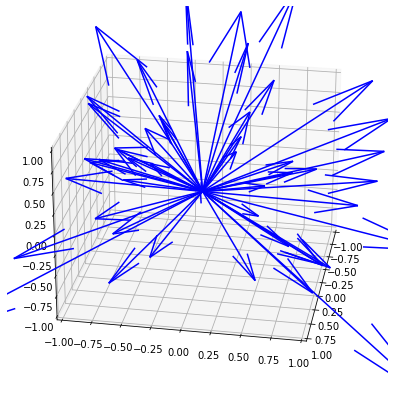

In [88]:
BAND_SIZE = 6
BATCH_SIZE = 50

model = MLP(
    band_size=BAND_SIZE,
    batch_size=BATCH_SIZE
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# show initial random embeddings
plot_embeddings(model.embs)

100 | Loss: -0.967, pos_loss:-1.000, neg_loss:-0.033
200 | Loss: -1.081, pos_loss:-1.000, neg_loss:0.081
300 | Loss: -1.050, pos_loss:-1.000, neg_loss:0.050
400 | Loss: -0.889, pos_loss:-1.000, neg_loss:-0.111
500 | Loss: -0.989, pos_loss:-1.000, neg_loss:-0.011
600 | Loss: -1.141, pos_loss:-1.000, neg_loss:0.141
700 | Loss: -1.058, pos_loss:-1.000, neg_loss:0.058
800 | Loss: -0.746, pos_loss:-1.000, neg_loss:-0.254
900 | Loss: -0.998, pos_loss:-1.000, neg_loss:-0.001
1000 | Loss: -0.973, pos_loss:-1.000, neg_loss:-0.027


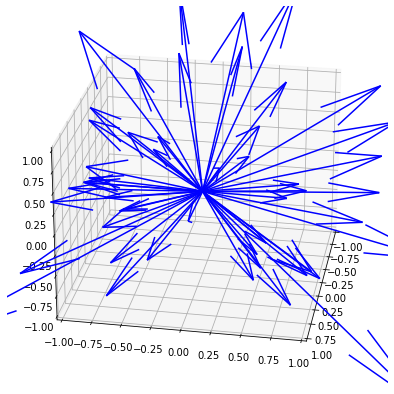

In [91]:
# training loop
for step in range(1000):

    # sample negative embeddings that is NOT equal to original index :-)
    neg_idx = shuffled_indices(model.embs.size(0))
    negs = model.embs[neg_idx, :]

    optimizer.zero_grad()
    hyps = model(model.embs)
    loss, p, n = loss_function(hyps, model.embs, negs)
    loss.backward()
    optimizer.step()

    if (step + 1) % 100 == 0:
        print(f"{step+1} | Loss: {loss.detach().item():.3f}, pos_loss:{p:.3f}, neg_loss:{n:.3f}")

# plot all embs
plot_embeddings(model.embs)

In [92]:
pred = predict(model.embs, hyps)
for true_idx, b in enumerate(pred):
    print(f"Contains answer: {(true_idx in b)}, len: {len(b)}")

Contains answer: True, len: 29
Contains answer: True, len: 25
Contains answer: True, len: 27
Contains answer: True, len: 29
Contains answer: True, len: 23
Contains answer: True, len: 23
Contains answer: True, len: 29
Contains answer: True, len: 21
Contains answer: True, len: 25
Contains answer: True, len: 28
Contains answer: True, len: 26
Contains answer: True, len: 24
Contains answer: True, len: 21
Contains answer: True, len: 22
Contains answer: True, len: 27
Contains answer: True, len: 27
Contains answer: True, len: 22
Contains answer: True, len: 27
Contains answer: True, len: 22
Contains answer: True, len: 22
Contains answer: True, len: 25
Contains answer: True, len: 24
Contains answer: True, len: 21
Contains answer: True, len: 26
Contains answer: True, len: 20
Contains answer: True, len: 24
Contains answer: True, len: 24
Contains answer: True, len: 25
Contains answer: True, len: 27
Contains answer: True, len: 26
Contains answer: True, len: 24
Contains answer: True, len: 24
Contains

In band: True, visualized:


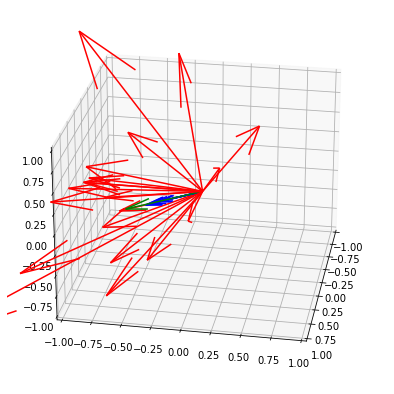

In [100]:
# plot one example with hyperplanes
id1 = random.randint(0, BATCH_SIZE-1)
plot_answerspace(model.embs, hyps, batch_id=id1)